In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load datasets
df = pd.read_csv('/content/drive/My Drive/UNSW_NB15_testing-set.csv')


In [4]:
# Preprocess the data
def preprocess_data(df):
    # Separate features and targets
    X = df.drop(['attack_cat', 'label'], axis=1)
    y_binary = df['label']
    y_multiclass = df['attack_cat']

    # Handle categorical variables
    categorical_cols = ['proto', 'service', 'state']
    X = pd.get_dummies(X, columns=categorical_cols)

    # Label encode the targets
    le_binary = LabelEncoder()
    le_multiclass = LabelEncoder()
    y_binary = le_binary.fit_transform(y_binary)
    y_multiclass = le_multiclass.fit_transform(y_multiclass)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Split the data into train, validation, and test sets
    X_train, X_temp, y_binary_train, y_binary_temp, y_multi_train, y_multi_temp = train_test_split(
        X_scaled, y_binary, y_multiclass, test_size=0.3, random_state=42)

    X_val, X_test, y_binary_val, y_binary_test, y_multi_val, y_multi_test = train_test_split(
        X_temp, y_binary_temp, y_multi_temp, test_size=0.5, random_state=42)

    return (X_train, X_val, X_test,
            y_binary_train, y_binary_val, y_binary_test,
            y_multi_train, y_multi_val, y_multi_test,
            le_binary, le_multiclass, scaler)


In [5]:
# Feature selection
def select_features(X, y, k=19):
    selector = SelectKBest(mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return X_selected, selected_features

In [6]:

# Hybrid Model 1: RandomForest + GradientBoosting
class HybridRFGB(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100):
        self.rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        self.gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

    def fit(self, X, y):
        self.rf.fit(X, y)
        self.gb.fit(X, y)
        return self

    def predict(self, X):
        rf_pred = self.rf.predict_proba(X)
        gb_pred = self.gb.predict_proba(X)
        return np.argmax((rf_pred + gb_pred) / 2, axis=1)

In [7]:
# Hybrid Model 2: XGBoost + LightGBM
class HybridXGBLGB(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100):
        self.xgb = xgb.XGBClassifier(n_estimators=n_estimators, random_state=42)
        self.lgb = lgb.LGBMClassifier(n_estimators=n_estimators, random_state=42)

    def fit(self, X, y):
        self.xgb.fit(X, y)
        self.lgb.fit(X, y)
        return self

    def predict(self, X):
        xgb_pred = self.xgb.predict_proba(X)
        lgb_pred = self.lgb.predict_proba(X)
        return np.argmax((xgb_pred + lgb_pred) / 2, axis=1)

In [8]:
# Hybrid Model 3: SVM + Neural Network
class HybridSVMNN(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.svm = SVC(probability=True, random_state=42)
        self.nn = MLPClassifier(random_state=42)

    def fit(self, X, y):
        self.svm.fit(X, y)
        self.nn.fit(X, y)
        return self

    def predict(self, X):
        svm_pred = self.svm.predict_proba(X)
        nn_pred = self.nn.predict_proba(X)
        return np.argmax((svm_pred + nn_pred) / 2, axis=1)

In [9]:
# Train and evaluate model
def train_evaluate_model(X_train, X_val, X_test, y_train, y_val, y_test, model, model_name):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f"{model_name} Results:")
    print(f"Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")
    print(f"Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}\n")

    return model, y_test_pred

In [10]:
# Visualize results
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



In [11]:
# Main execution
X_train, X_val, X_test, y_binary_train, y_binary_val, y_binary_test, y_multi_train, y_multi_val, y_multi_test, le_binary, le_multiclass, scaler = preprocess_data(df)

Binary Classification
Hybrid RandomForest + GradientBoosting Results:
Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Test - Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1-score: 0.9999



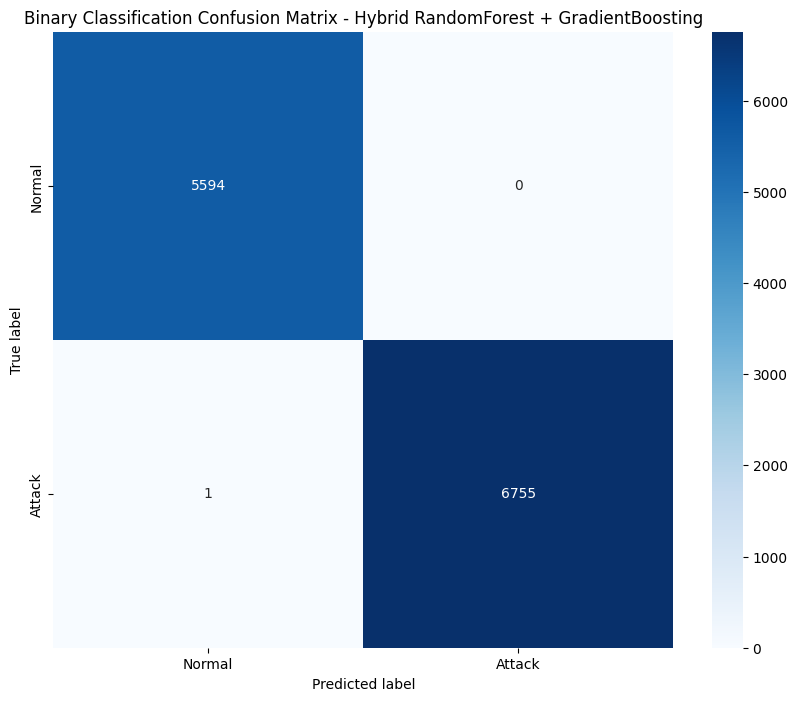

[LightGBM] [Info] Number of positive: 31779, number of negative: 25853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6336
[LightGBM] [Info] Number of data points in the train set: 57632, number of used features: 167
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551412 -> initscore=0.206379
[LightGBM] [Info] Start training from score 0.206379
Hybrid XGBoost + LightGBM Results:
Validation - Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1-score: 0.9998
Test - Accuracy: 0.9997, Precision: 0.9997, Recall: 0.9997, F1-score: 0.9997



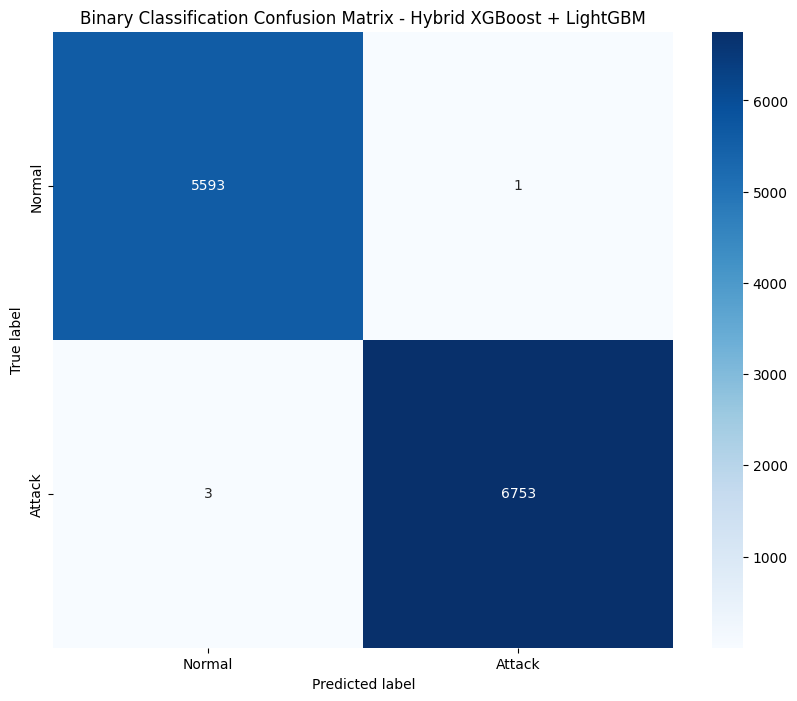

Hybrid SVM + Neural Network Results:
Validation - Accuracy: 0.9938, Precision: 0.9938, Recall: 0.9938, F1-score: 0.9938
Test - Accuracy: 0.9943, Precision: 0.9943, Recall: 0.9943, F1-score: 0.9942



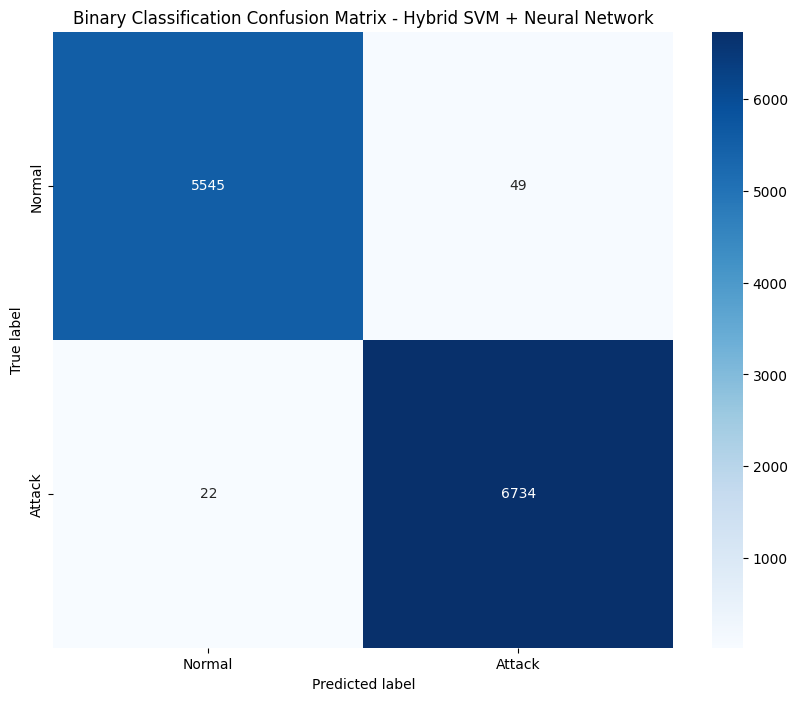

In [12]:
# Binary Classification
print("Binary Classification")
hybrid_models = [
    (HybridRFGB(), "Hybrid RandomForest + GradientBoosting"),
    (HybridXGBLGB(), "Hybrid XGBoost + LightGBM"),
    (HybridSVMNN(), "Hybrid SVM + Neural Network")
]

for model, name in hybrid_models:
    _, y_pred_binary = train_evaluate_model(X_train, X_val, X_test, y_binary_train, y_binary_val, y_binary_test, model, name)
    plot_confusion_matrix(y_binary_test, y_pred_binary, classes=['Normal', 'Attack'], title=f'Binary Classification Confusion Matrix - {name}')


Multi-class Classification
Hybrid RandomForest + GradientBoosting Results:
Validation - Accuracy: 0.8989, Precision: 0.8979, Recall: 0.8989, F1-score: 0.8978
Test - Accuracy: 0.8996, Precision: 0.8990, Recall: 0.8996, F1-score: 0.8984



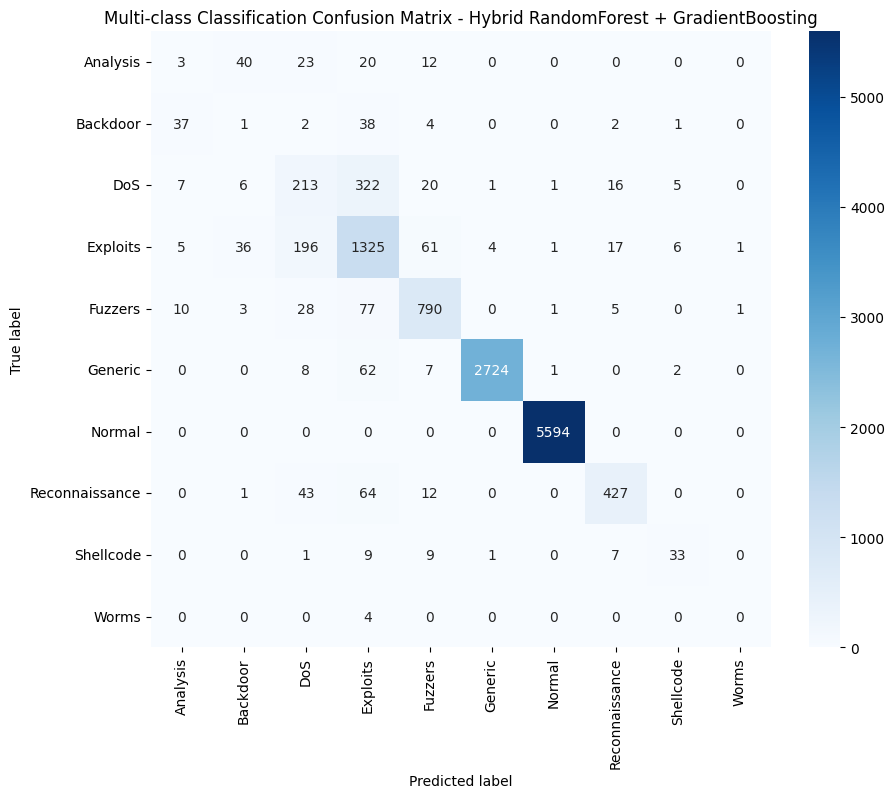

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6336
[LightGBM] [Info] Number of data points in the train set: 57632, number of used features: 167
[LightGBM] [Info] Start training from score -4.815504
[LightGBM] [Info] Start training from score -4.953020
[LightGBM] [Info] Start training from score -2.987989
[LightGBM] [Info] Start training from score -2.002522
[LightGBM] [Info] Start training from score -2.604574
[LightGBM] [Info] Start training from score -1.471138
[LightGBM] [Info] Start training from score -0.801651
[LightGBM] [Info] Start training from score -3.165364
[LightGBM] [Info] Start training from score -5.405005
[LightGBM] [Info] Start training from score -7.465326
Hybrid XGBoost + LightGBM Results:
Validation - Accuracy: 0.8757, Precision: 0.8793, Recall: 0.8757, F1-sc

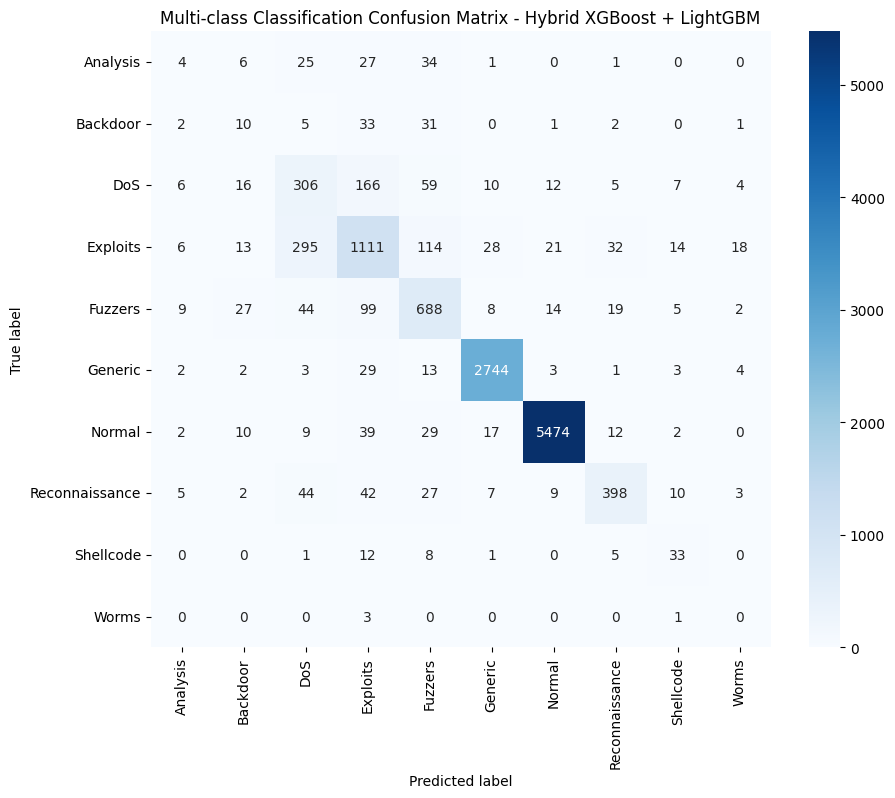

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hybrid SVM + Neural Network Results:
Validation - Accuracy: 0.8816, Precision: 0.8771, Recall: 0.8816, F1-score: 0.8737
Test - Accuracy: 0.8801, Precision: 0.8680, Recall: 0.8801, F1-score: 0.8717



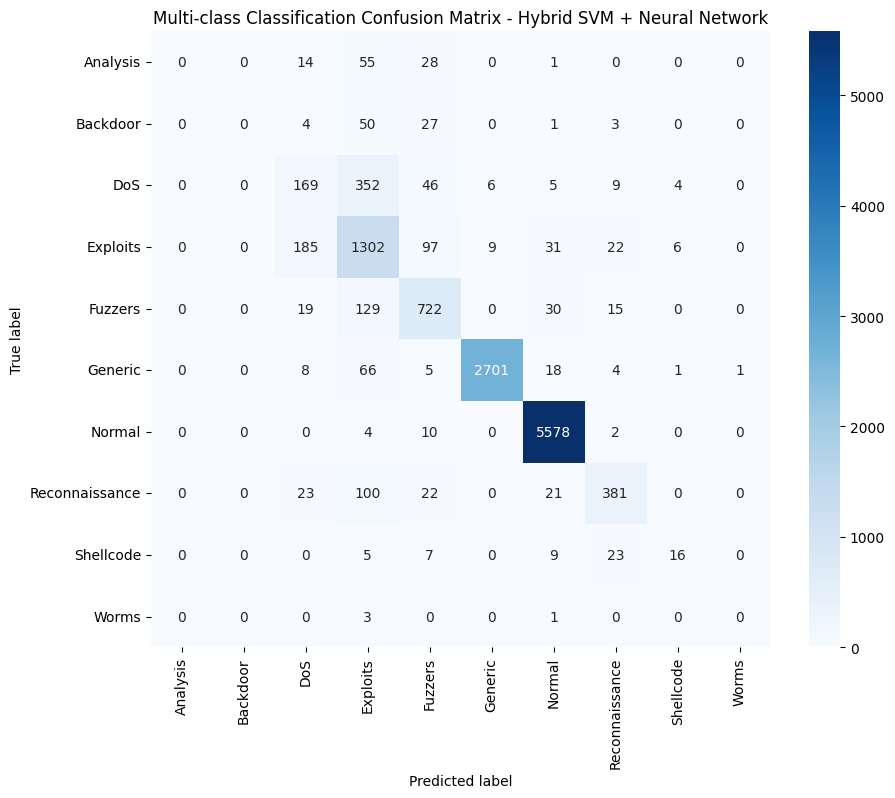

In [13]:
# Multi-class Classification
print("Multi-class Classification")
for model, name in hybrid_models:
    _, y_pred_multi = train_evaluate_model(X_train, X_val, X_test, y_multi_train, y_multi_val, y_multi_test, model, name)
    plot_confusion_matrix(y_multi_test, y_pred_multi, classes=le_multiclass.classes_, title=f'Multi-class Classification Confusion Matrix - {name}')

In [15]:
import joblib
import os

def save_hybrid_model(model, scaler, le, save_path):
    os.makedirs(save_path, exist_ok=True)

    # Save the RandomForest and GradientBoosting components
    joblib.dump(model.rf, f"{save_path}/random_forest_model.joblib")
    joblib.dump(model.gb, f"{save_path}/gradient_boosting_model.joblib")

    # Save the scaler and label encoder
    joblib.dump(scaler, f"{save_path}/scaler.joblib")
    joblib.dump(le, f"{save_path}/label_encoder.joblib")

    print(f"Model components saved to {save_path}")

# Assuming the best model is the first one (RandomForest + GradientBoosting)
best_binary_model, _ = train_evaluate_model(X_train, X_val, X_test, y_binary_train, y_binary_val, y_binary_test, HybridRFGB(), "Best Binary Model")
best_multi_model, _ = train_evaluate_model(X_train, X_val, X_test, y_multi_train, y_multi_val, y_multi_test, HybridRFGB(), "Best Multiclass Model")

# Save the binary classification model
save_hybrid_model(best_binary_model, scaler, le_binary, "/content/saved_model_binary")

# Save the multiclass classification model
save_hybrid_model(best_multi_model, scaler, le_multiclass, "/content/saved_model_multiclass")

print("Best models have been saved.")

# If you're using Google Colab and want to download the saved models:
from google.colab import files
!zip -r best_models.zip /content/saved_model_binary /content/saved_model_multiclass
files.download('best_models.zip')

Best Binary Model Results:
Validation - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Test - Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1-score: 0.9999

Best Multiclass Model Results:
Validation - Accuracy: 0.8989, Precision: 0.8979, Recall: 0.8989, F1-score: 0.8978
Test - Accuracy: 0.8996, Precision: 0.8990, Recall: 0.8996, F1-score: 0.8984

Model components saved to /content/saved_model_binary
Model components saved to /content/saved_model_multiclass
Best models have been saved.
  adding: content/saved_model_binary/ (stored 0%)
  adding: content/saved_model_binary/random_forest_model.joblib (deflated 80%)
  adding: content/saved_model_binary/label_encoder.joblib (deflated 25%)
  adding: content/saved_model_binary/scaler.joblib (deflated 53%)
  adding: content/saved_model_binary/gradient_boosting_model.joblib (deflated 74%)
  adding: content/saved_model_multiclass/ (stored 0%)
  adding: content/saved_model_multiclass/random_forest_model.joblib (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# New Section